In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd data

/Users/chrisbarnard/Documents/Programming/Python/getting_started/MedCamp Hackathon/data


# Pull in data sources
## Test Data

In [3]:
def loadTestData():
    test_data = pd.read_csv('Test.csv',sep=',', parse_dates=[2], index_col=['Patient_ID', 'Health_Camp_ID'])
    return test_data

## Training Data

In [4]:
def loadTrainData():
    train_data = pd.read_csv('Train/Train.csv',sep=',', parse_dates=[2], index_col=['Patient_ID', 'Health_Camp_ID'])
    return train_data

## Merge in some other key fields
### Define a function that will merge in all other fields into dataset

In [5]:
def getData(sourceData):
    HC1 = pd.read_csv('Train/First_Health_Camp_Attended.csv', sep=',', index_col=['Patient_ID', 'Health_Camp_ID'])
    HC1.pop('Unnamed: 4')
    sourceData['Health_Camp_Score_1'] = HC1['Health_Score']
    sourceData['Health_Camp_Attended_1'] = sourceData['Health_Camp_Score_1'].apply(lambda x: True if x > 0 else False)

    HC2 = pd.read_csv('Train/Second_Health_Camp_Attended.csv', sep=',', index_col=['Patient_ID','Health_Camp_ID'])
    sourceData['Health_Camp_Score_2'] = HC2['Health Score']
    sourceData['Health_Camp_Attended_2'] = sourceData['Health_Camp_Score_2'].apply(lambda x: True if x > 0 else False)

    HC3 = pd.read_csv('Train/Third_Health_Camp_Attended.csv', sep=',', index_col=['Patient_ID','Health_Camp_ID'])
    sourceData['Health_Camp_Stalls_3'] = HC3['Number_of_stall_visited']
    sourceData['Health_Camp_Attended_3'] = sourceData['Health_Camp_Stalls_3'].apply(lambda x: True if x > 0 else False)

    ### Positive_Result

    sourceData['Positive_Result'] = (sourceData['Health_Camp_Attended_1'] | sourceData['Health_Camp_Attended_2'] | sourceData['Health_Camp_Attended_3'])

    ### Health_Camp_Details

    HCDetails = pd.read_csv('Train/Health_Camp_Detail.csv', sep=',', index_col='Health_Camp_ID', parse_dates=[1,2])
    sourceData = sourceData.join(HCDetails)

    ### Patient Details

    PatientProfiles = pd.read_csv('Train/Patient_Profile.csv', sep=',', index_col='Patient_ID', parse_dates=[8])
    sourceData = sourceData.join(PatientProfiles)

    ### Add in the reg_num

    df = sourceData[['Registration_Date','Positive_Result']]
    df.reset_index(level=['Patient_ID','Health_Camp_ID'], inplace=1)
    hist = df.sort_values(by=['Patient_ID','Registration_Date'])
    hist.set_index(['Patient_ID','Health_Camp_ID'], inplace=1)

    sourceData['reg_num'] = hist.groupby(level=0).cumcount()
    
    ### Repeat Register Flag
    sourceData['rep_reg'] = sourceData['reg_num'].apply(lambda x: True if x > 0 else False)
    
    ### rep_reg_bin

    # define a bin size
    size = 8
    bins = np.logspace(np.log2(0.99), np.log2(sourceData.reg_num.max()), size, endpoint=True, base=2)

    sourceData['rep_reg_bin'] = pd.cut(sourceData.reg_num, bins).cat.rename_categories([1,2,3,4,5,6,7])
    sourceData['rep_reg_bin'] = sourceData['rep_reg_bin'].cat.add_categories(-1)
    sourceData['rep_reg_bin'] = sourceData['rep_reg_bin'].fillna(-1)
    
    #train_data['rep_reg_bin'] = train_data['rep_reg_bin'].cat.rename_categories([1,2,3,4,5,6,7])
    
    ### has_var
    sourceData['has_var'] = (sourceData['Var1'] > 0) | (sourceData['Var2'] > 0) | (sourceData['Var3'] > 0) | (sourceData['Var4'] > 0) | (sourceData['Var5'] > 0) 
    
    ### v1_b
    # define a bin size
    #size = 5
    #bins = np.logspace(np.log2(.99), np.log2(sourceData.Var1.max()), size, endpoint=True, base=2)

    #sourceData['v1_b'] = pd.cut(sourceData.Var1, bins).cat.rename_categories([1,2,3,4])
    #sourceData['v1_b'] = sourceData['v1_b'].cat.add_categories(-1)
    #sourceData['v1_b'] = sourceData['v1_b'].fillna(-1)
    
    ### online   
    sourceData['online'] = (sourceData['Online_Follower']) | (sourceData['LinkedIn_Shared']) | (sourceData['Twitter_Shared']) | (sourceData['Facebook_Shared'])
    
    ### City_Type
    sourceData['City_Type'] = sourceData['City_Type'].fillna('Z')
    
    ### Age
    val_counts = sourceData['Age'].value_counts().to_dict()
    for key, value in val_counts.items():
        if key == 'None':
            val_counts[key] = None
        else:
            val_counts[key] = int(key)
    val_counts
    sourceData['Age'] = sourceData['Age'].apply(lambda x: val_counts.get(x))
    
    ### age_b
    size = 5
    bins = np.linspace(0,sourceData.Age.max(), size, endpoint=True)

    sourceData['age_b'] = pd.cut(sourceData.Age, bins).cat.rename_categories([1,2,3,4])
    sourceData['age_b'] = sourceData['age_b'].cat.add_categories(-1)
    sourceData['age_b'] = sourceData['age_b'].fillna(-1)
    
    return sourceData



In [6]:
train_data = getData(loadTrainData())
train_data.head()

,,Registration_Date,Var1,Var2,Var3,Var4,Var5,Health_Camp_Score_1,Health_Camp_Attended_1,Health_Camp_Score_2,Health_Camp_Attended_2,...,Age,First_Interaction,City_Type,Employer_Category,reg_num,rep_reg,rep_reg_bin,has_var,online,age_b
Patient_ID,Health_Camp_ID,,,,,,,,,,,,,,,,,,,,,
489652,6578,2005-09-10,4,0,0,0,2,NaN,False,NaN,False,...,NaN,2004-12-06,Z,NaN,8,True,5,True,0,-1
507246,6578,2005-08-18,45,5,0,0,7,NaN,False,NaN,False,...,40.0,2004-09-08,C,Others,11,True,5,True,0,2
523729,6534,2006-04-29,0,0,0,0,0,NaN,False,0.402054,True,...,NaN,2004-06-22,Z,NaN,4,True,3,False,0,-1
524931,6535,2004-02-07,0,0,0,0,0,NaN,False,NaN,False,...,NaN,2004-02-07,I,NaN,0,False,-1,False,0,-1
521364,6529,2006-02-28,15,1,0,0,7,NaN,False,0.845597,True,...,40.0,2003-07-04,I,Technology,16,True,6,True,1,2


In [7]:
### var1-5 train_data
vars = ['Var2','Var3','Var4','Var5']
from sklearn.preprocessing import Normalizer
scaler = {}
for var in vars:
    scaler[var] = Normalizer().fit(train_data[var].reshape(-1,1))
    train_data[var] = scaler[var].transform(train_data[var].reshape(-1,1)).reshape(1,-1)[0]

# bin for Var1
### v1_b
# define a bin size
size = 5
scaler['Var1'] = np.logspace(np.log2(.99), np.log2(train_data.Var1.max()), size, endpoint=True, base=2)
print(scaler['Var1'])
train_data['v1_b'] = pd.cut(train_data.Var1, scaler['Var1']).cat.rename_categories([1,2,3,4])
train_data['v1_b'] = train_data['v1_b'].cat.add_categories(-1)
train_data['v1_b'] = train_data['v1_b'].fillna(-1)

train_data[train_data['Var1'] == 1].head()

[   0.99          4.088599     16.88549674   69.73537882  288.        ]


/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


,,Registration_Date,Var1,Var2,Var3,Var4,Var5,Health_Camp_Score_1,Health_Camp_Attended_1,Health_Camp_Score_2,Health_Camp_Attended_2,...,First_Interaction,City_Type,Employer_Category,reg_num,rep_reg,rep_reg_bin,has_var,online,age_b,v1_b
Patient_ID,Health_Camp_ID,,,,,,,,,,,,,,,,,,,,,
486243,6526,2004-12-02,1,0.0,0.0,0.0,0.0,NaN,False,NaN,False,...,2003-07-23,B,NaN,2,True,2,True,0,3,1
504508,6580,2004-11-20,1,0.0,0.0,0.0,1.0,NaN,False,NaN,False,...,2003-05-24,Z,NaN,0,False,-1,True,0,-1,1
519630,6538,2004-12-02,1,0.0,0.0,0.0,0.0,NaN,False,NaN,False,...,2003-04-07,B,Technology,2,True,2,True,0,2,1
517351,6538,2004-01-22,1,0.0,0.0,0.0,0.0,NaN,False,NaN,False,...,2003-02-08,B,NaN,0,False,-1,True,0,-1,1
510776,6526,2005-01-01,1,0.0,0.0,0.0,0.0,NaN,False,NaN,False,...,2004-09-08,Z,NaN,2,True,2,True,0,-1,1


In [8]:
test_data = getData(loadTestData())
drops = ['Health_Camp_Score_1','Health_Camp_Attended_1','Health_Camp_Score_2','Health_Camp_Attended_2','Health_Camp_Stalls_3','Health_Camp_Attended_3','Positive_Result']
for col in drops:
    test_data.pop(col)
test_data.head()

,,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,Category1,Category2,...,Age,First_Interaction,City_Type,Employer_Category,reg_num,rep_reg,rep_reg_bin,has_var,online,age_b
Patient_ID,Health_Camp_ID,,,,,,,,,,,,,,,,,,,,,
505701,6548,2006-05-21,1,0,0,0,2,2006-06-13,2006-08-18,Third,G,...,44.0,2003-02-05,E,NaN,2,True,2,True,0,3
500633,6584,2006-06-02,0,0,0,0,0,2006-08-04,2006-08-09,Second,A,...,41.0,2004-12-11,D,Consulting,1,True,1,False,1,3
506945,6582,2006-08-10,0,0,0,0,0,2006-04-06,2007-11-07,First,F,...,NaN,2006-04-19,Z,NaN,3,True,3,False,0,-1
497447,6551,2006-08-27,0,0,0,0,0,2006-11-13,2006-11-18,Second,D,...,47.0,2006-08-25,B,NaN,1,True,1,False,0,3
496446,6533,2006-09-19,0,0,0,0,0,2006-09-20,2006-09-23,First,E,...,NaN,2006-09-19,B,NaN,0,False,-1,False,0,-1


In [9]:
### var1-5 test_data
for var in vars:
    test_data[var] = scaler[var].transform(test_data[var].reshape(-1,1)).reshape(1,-1)[0]

test_data['v1_b'] = pd.cut(test_data.Var1, scaler['Var1']).cat.rename_categories([1,2,3,4])
test_data['v1_b'] = test_data['v1_b'].cat.add_categories(-1)
test_data['v1_b'] = test_data['v1_b'].fillna(-1)

test_data.head()

/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


,,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,Category1,Category2,...,First_Interaction,City_Type,Employer_Category,reg_num,rep_reg,rep_reg_bin,has_var,online,age_b,v1_b
Patient_ID,Health_Camp_ID,,,,,,,,,,,,,,,,,,,,,
505701,6548,2006-05-21,1,0.0,0.0,0.0,1.0,2006-06-13,2006-08-18,Third,G,...,2003-02-05,E,NaN,2,True,2,True,0,3,1
500633,6584,2006-06-02,0,0.0,0.0,0.0,0.0,2006-08-04,2006-08-09,Second,A,...,2004-12-11,D,Consulting,1,True,1,False,1,3,-1
506945,6582,2006-08-10,0,0.0,0.0,0.0,0.0,2006-04-06,2007-11-07,First,F,...,2006-04-19,Z,NaN,3,True,3,False,0,-1,-1
497447,6551,2006-08-27,0,0.0,0.0,0.0,0.0,2006-11-13,2006-11-18,Second,D,...,2006-08-25,B,NaN,1,True,1,False,0,3,-1
496446,6533,2006-09-19,0,0.0,0.0,0.0,0.0,2006-09-20,2006-09-23,First,E,...,2006-09-19,B,NaN,0,False,-1,False,0,-1,-1


# Begin Exploratory Analysis
## Looking into what the variables tell us
### Categorie1 of the HealthCampDetail
There seems to be a horrible pull-through on the First value for Category1

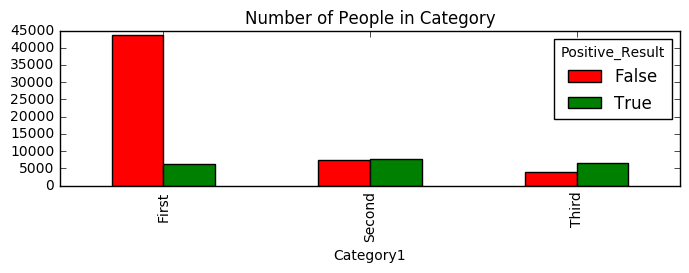

In [10]:
cat_1 = train_data[['Category1','Positive_Result']].groupby(['Positive_Result','Category1']).size().unstack(0)
cat_1.plot(kind='bar', color=['red','green'], title='Number of People in Category', figsize=(8,2))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1179a36d8>], dtype=object)

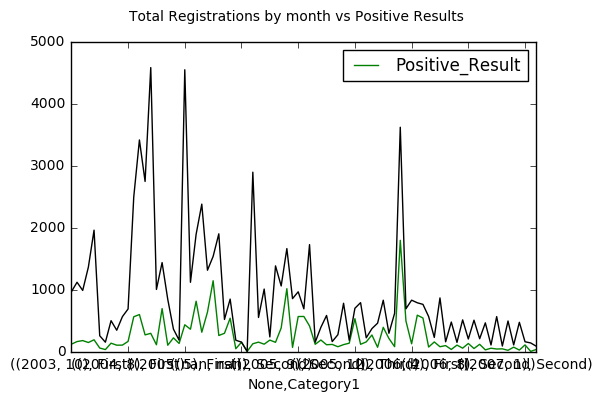

In [11]:
ts = train_data[['Positive_Result','Registration_Date','Category1']].set_index('Registration_Date')
grouped = ts.groupby([lambda x: (x.year, x.month), 'Category1']).sum()
grouped2 = ts.groupby([lambda x: (x.year, x.month), 'Category1']).size()
grouped.plot(color='green')
grouped2.plot(subplots=True, color='black', title='Total Registrations by month vs Positive Results')

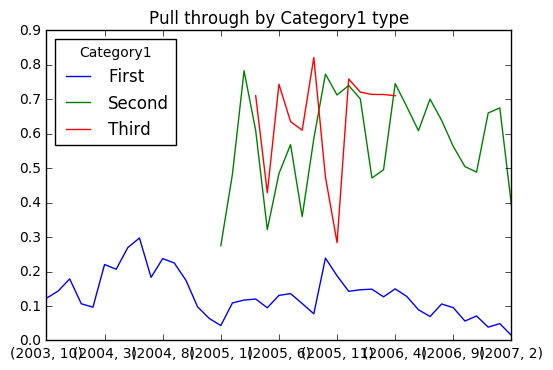

In [12]:
ts = train_data[['Positive_Result','Registration_Date','Category1']]
grouped = ts.groupby(['Registration_Date', 'Category1'])
#grouped2 = ts.groupby([lambda x: (x.year, x.month), 'Category1']).size()
df = grouped.sum()
df['Total'] = grouped.count()

monthly = df.unstack().groupby(lambda x: (x.year, x.month)).sum()
#monthly['positive_pct'] = monthly['Positive_Result'] / monthly['Total']
pull_through_monthly = monthly['Positive_Result'] / monthly['Total']
#monthly
pull_through_monthly.plot(title='Pull through by Category1 type')

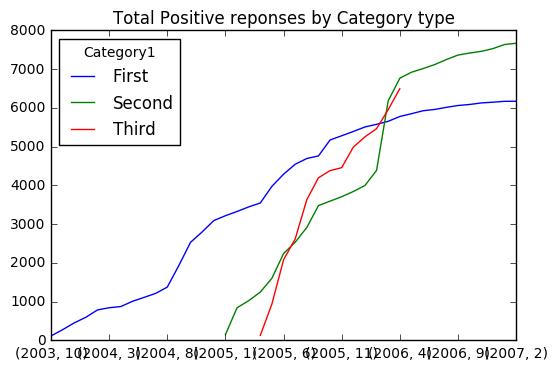

In [13]:
monthly['Positive_Result'].cumsum().plot(title='Total Positive reponses by Category type', kind='line')

### OK, Let's look at category1 compared to Health_Camp_Attended
It seems that category1 perfectly matches which health camp they attended

In [14]:
df = train_data[['Health_Camp_Score_1','Health_Camp_Score_2','Health_Camp_Stalls_3','Health_Camp_Attended_1','Health_Camp_Attended_2','Health_Camp_Attended_3','Category1']]
df['counter'] = 1
df.pivot_table(values='counter', index='Category1', columns=['Health_Camp_Attended_1','Health_Camp_Attended_2','Health_Camp_Attended_3'])

/Users/chrisbarnard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Health_Camp_Attended_1 False             True 
Health_Camp_Attended_2 False       True  False
Health_Camp_Attended_3 False True  False False
Category1                                     
First                    1.0   NaN   NaN   1.0
Second                   1.0   NaN   1.0   NaN
Third                    1.0   1.0   NaN   NaN

### Category2

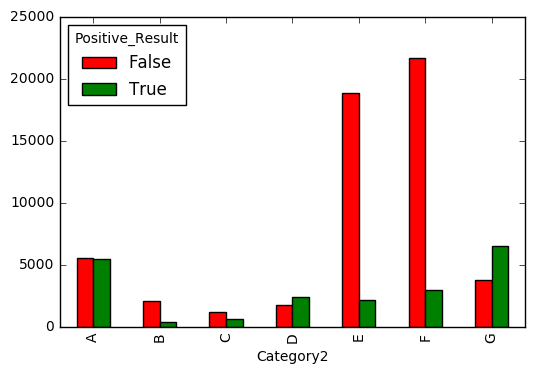

In [15]:
df = train_data[['Category2','Positive_Result','Health_Camp_Attended_1','Health_Camp_Attended_2','Health_Camp_Attended_3','Category1','Category3']]
grouped = df.groupby(['Category2','Positive_Result'])
grouped.size().unstack()
grouped.size().unstack().plot(kind='bar', color=['red','green'])

#### Let's bring in category1 to confirm that E & F are the same spike before
And E and F were indead all from the first category of camps

In [16]:
cols = ['Positive_Result','Category2','Category1']
df.groupby(cols).size().unstack([0,2])

Positive_Result   False                    True                 
Category1        Second    First   Third  Second   First   Third
Category2                                                       
A                5554.0      NaN     NaN  5439.0     NaN     NaN
B                   NaN   2039.0     NaN     NaN   387.0     NaN
C                   NaN   1163.0     NaN     NaN   655.0     NaN
D                1741.0      NaN     NaN  2380.0     NaN     NaN
E                   NaN  18813.0     NaN     NaN  2175.0     NaN
F                   NaN  21659.0     NaN     NaN  3001.0     NaN
G                   NaN      NaN  3775.0     NaN     NaN  6497.0

### Category3
It seems specific to the F and E values for category2.  Maybe this can help deal the large number of dropouts in that bucket.  The variable is very weighted towards a value of 2 for almost every value

In [17]:
cols = ['Positive_Result','Category2','Category3']
df.groupby(cols).size().unstack([0,2])

Positive_Result    False          True       
Category3              2      1       2     1
Category2                                    
A                 5554.0    NaN  5439.0   NaN
B                 2039.0    NaN   387.0   NaN
C                 1163.0    NaN   655.0   NaN
D                 1741.0    NaN  2380.0   NaN
E                18625.0  188.0  2084.0  91.0
F                21544.0  115.0  2988.0  13.0
G                 3775.0    NaN  6497.0   NaN

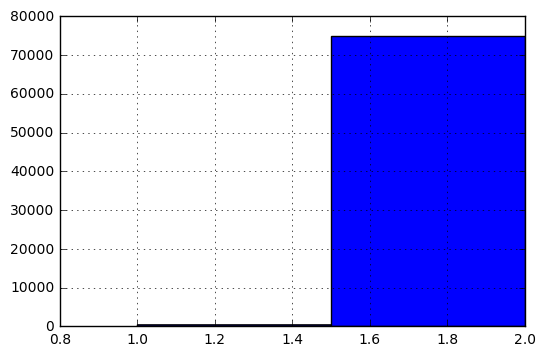

In [18]:
train_data['Category3'].hist(bins=2)

### Let's look at whether they have a previous Registration

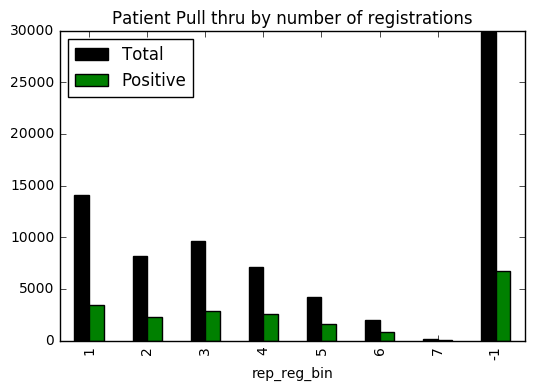

In [19]:
groups = train_data.groupby('rep_reg_bin')

tot = groups.size()
pos = groups.sum()['Positive_Result']
pt = pos / tot
df = pd.DataFrame()
df['Total'] = tot
df['Positive'] = pos

df.plot(title='Patient Pull thru by number of registrations', kind='bar', color=['black', 'green'])


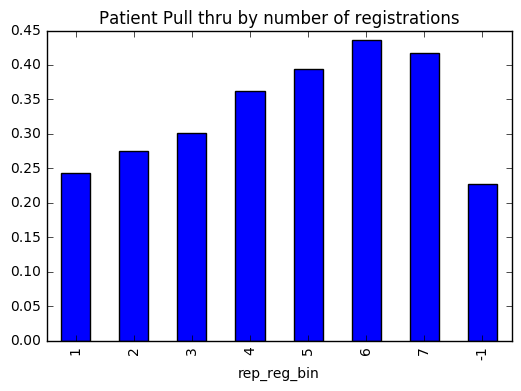

In [20]:

tot = groups.size()
pos = groups.sum()['Positive_Result']
pt = pos / tot

pt.plot(title='Patient Pull thru by number of registrations', kind='bar')


### Let's look at Var1-5
These variables don't seem to be leading me anywhere, best result so far is just normalizing them to a binary flag
#### has_var

In [21]:
df = train_data[['Var1','Var2','Var3','Var4','Var5','Positive_Result','has_var','v1_b']]
df.groupby(['has_var','Positive_Result']).size().unstack().head()

Positive_Result,False,True
has_var,,
False,49648,17797
True,5096,2737


#### Var1

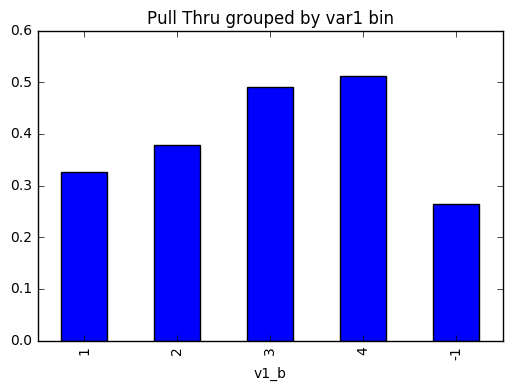

In [22]:
v1_b = df.groupby(['v1_b','Positive_Result']).size().unstack()
v1_b['prob'] = v1_b[True] / (v1_b[False] + v1_b[True])
v1_b['prob'].plot(kind='bar', title='Pull Thru grouped by var1 bin')


#### Var2


In [23]:
v2 = df.groupby(['Var2','Positive_Result']).size().unstack()
v2.head()

Positive_Result,False,True
Var2,,
0.0,53266,19566
1.0,1478,968


## Social Media

In [24]:
train_data.groupby(['Positive_Result','online']).size().unstack(0)

Positive_Result,False,True
online,,
0,49509,17610
1,5235,2924


## City Type

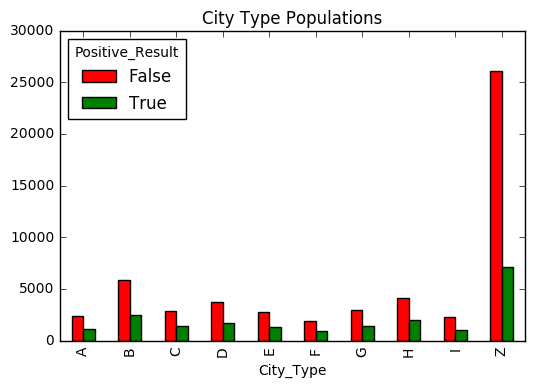

In [25]:
train_data.groupby(['City_Type','Positive_Result']).size().unstack().plot(kind='bar', title='City Type Populations', color=['red','green'])

## Age

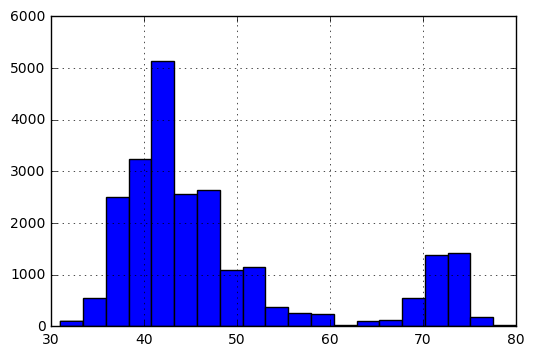

In [26]:
train_data.Age.hist(bins=20)

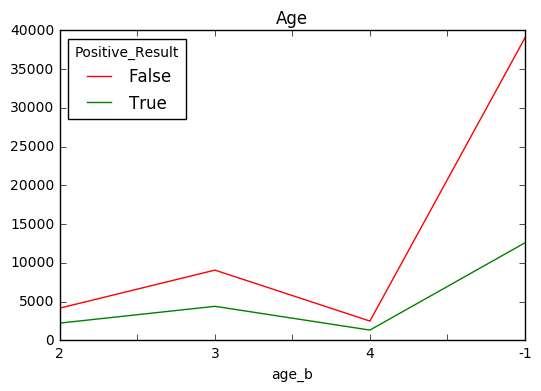

In [27]:
#train_data['Age'] = train_data[no_age]['Age'].apply(cleanAge)
train_data.groupby(['age_b','Positive_Result']).size().unstack().plot(title='Age', color=['red','green'], kind='line')

# Bring in main model function

In [28]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome])

### Encode the data for sklearn

In [29]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Category1','Category2','Category3','rep_reg_bin','City_Type','age_b','online','v1_b','Var2','Var3','Var4','Var5']
le = LabelEncoder()
for i in var_mod:
    train_data[i] = le.fit_transform(train_data[i])
#train_data.dtypes

In [30]:
for i in var_mod:
    test_data[i] = le.fit_transform(test_data[i])

### Pick the model that we want to use and fit the model

In [31]:
outcome_var = 'Positive_Result'
model = LinearSVC(tol=0.00001)
predictor_var = ['Category1','Category2','Category3','rep_reg_bin','City_Type','age_b','online','v1_b','Var2','Var3','Var4','Var5']
classification_model(model, train_data, predictor_var, outcome_var)

Accuracy : 76.752%
Cross-Validation Score : 76.722%


In [32]:
#Version for LinearSVC
clf = CalibratedClassifierCV(model)
clf.fit(train_data[predictor_var],train_data[outcome_var])
results = clf.predict_proba(test_data[predictor_var])
formatted = list()
for pFalse,pTrue  in results:
    formatted.append(pTrue)

outcome = pd.Series(formatted, index=test_data.index)

test_data['Outcome'] = outcome
#test_data['Outcome'].to_csv('output.csv', header=True)

# Look into results
## What values do we miss on the training sample?

In [33]:
# null accuracy for the problem
train_data.Positive_Result.value_counts().head(1) / len(train_data.Positive_Result)

False    0.727224
Name: Positive_Result, dtype: float64

### Confusion Matrix 

In [34]:
# confusion matrix
train_data['predicted'] = model.predict(train_data[predictor_var])
train_data.groupby(['predicted','Positive_Result']).size().unstack(0)

predicted,False,True
Positive_Result,,
False,48554,6190
True,11297,9237


In [35]:
confusion = metrics.confusion_matrix(train_data.Positive_Result, train_data.predicted)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

### Classification Accuracy - *How often is the classifier correct?*

In [36]:
print((TP + TN) / (FP + FN + TP + TN))
print(metrics.accuracy_score(train_data.Positive_Result, train_data.predicted))

0.767701054757
0.767701054757


### Sensitivity - *When the actual value is positive, how often is the prediction correct?*
 * How 'sensitive' or selective is the model with detecting a positive instance?

In [37]:
print((TP) / (TP + FN))
print(metrics.recall_score(train_data.Positive_Result, train_data.predicted))

0.449839290932
0.449839290932


### Specificity - *When the actual value is negative, how often is the prediction correct?*

In [38]:
(TN) / (TN + FP)

0.88692824784451263

### False Positives Rate - *When the actual value is negative, how often is the prediction incorrect?*

In [39]:
FP / (FP + TN)

0.11307175215548736

### Precision - *When a positive value is predicted, how often is the prediction correct?*
 * How precise the classifier is when selecting a positive instance?

In [40]:
print(TP / (TP + FP))
print(metrics.precision_score(train_data.Positive_Result, train_data.predicted))

0.598755428794
0.598755428794


In [41]:
print(metrics.classification_report(train_data['Positive_Result'], train_data['predicted'], target_names=['False', 'True']))

             precision    recall  f1-score   support

      False       0.81      0.89      0.85     54744
       True       0.60      0.45      0.51     20534

avg / total       0.75      0.77      0.76     75278



## Grid Search for model parameters


In [42]:
from sklearn.grid_search import GridSearchCV
# define values I want to use:
c_values = list(np.logspace(np.log2(0.001),np.log2(0.01),10, base=2))

param_grid = dict(C=c_values)

grid = GridSearchCV(LinearSVC(), param_grid=param_grid, cv=None, scoring='roc_auc', verbose=1, n_jobs=3)
grid.fit(train_data[predictor_var],train_data.Positive_Result)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    5.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'C': [0.001, 0.0012915496650148833, 0.0016681005372000594, 0.0021544346900318834, 0.0027825594022071231, 0.003593813663804628, 0.0046415888336127781, 0.0059948425031894096, 0.0077426368268112711, 0.010000000000000002]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [43]:
grid.best_params_

{'C': 0.0046415888336127781}

In [44]:
grid.best_score_

0.79693453440618944

In [45]:
grid.grid_scores_

[mean: 0.79673, std: 0.00422, params: {'C': 0.001},
 mean: 0.79683, std: 0.00425, params: {'C': 0.0012915496650148833},
 mean: 0.79685, std: 0.00432, params: {'C': 0.0016681005372000594},
 mean: 0.79689, std: 0.00433, params: {'C': 0.0021544346900318834},
 mean: 0.79691, std: 0.00434, params: {'C': 0.0027825594022071231},
 mean: 0.79689, std: 0.00428, params: {'C': 0.003593813663804628},
 mean: 0.79693, std: 0.00427, params: {'C': 0.0046415888336127781},
 mean: 0.79693, std: 0.00424, params: {'C': 0.0059948425031894096},
 mean: 0.79692, std: 0.00423, params: {'C': 0.0077426368268112711},
 mean: 0.79692, std: 0.00426, params: {'C': 0.010000000000000002}]

In [46]:
outcome_var = 'Positive_Result'
model = LinearSVC(C=grid.best_params_['C'])
#predictor_var = ['Category1','Category2','Category3','rep_reg_bin','City_Type','online','v1_b','Var2','Var3','Var4','Var5']
classification_model(model, train_data, predictor_var, outcome_var)

Accuracy : 76.757%
Cross-Validation Score : 76.766%


In [47]:
#Version for LinearSVC
clf = CalibratedClassifierCV(model)
clf.fit(train_data[predictor_var],train_data[outcome_var])
results = clf.predict_proba(test_data[predictor_var])
formatted = list()
for pFalse,pTrue  in results:
    formatted.append(pTrue)

outcome = pd.Series(formatted, index=test_data.index)

test_data['Outcome2'] = outcome
test_data['Outcome'].to_csv('output.csv', header=True)